[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/juansensio/blog/blob/master/108_cfd_mat/108_cfd_mat.ipynb)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
from mesh import Mesh
import time
import numpy as np 
import math
import fluxes 
import temporal_schemes 
from bocos import DirichletBC, NeumannBC
import time 

def plot(mesh, p, t):
	fig = plt.figure(figsize=(10, 5))
	ax1 = fig.add_subplot(111, projection='3d')
	mesh.plot_field(p, ax1, f't = {t:.3f}')
	plt.show()

vel = lambda x, y: np.array([2.*y*(1-x**2), -2.*x*(1-y**2)])

def simulate(mesh, ALPHA, tf, CFL=1., ss='upwind', ts='euler', max_its=None):
	t0 = time.time()
	p0 = np.zeros_like(mesh.c)
	bcl = DirichletBC([i for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[0]], [1 - math.tanh(ALPHA) for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[0]])
	bcr = DirichletBC([i for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[1]], [1 - math.tanh(ALPHA) for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[1]])
	bct = DirichletBC([i for i in mesh.fb if mesh.f[i].c.x == mesh.Ly[1]], [1 - math.tanh(ALPHA) for i in mesh.fb if mesh.f[i].c.x == mesh.Ly[1]])
	bcbl = DirichletBC([i for i in mesh.fb if mesh.f[i].c.y == mesh.Ly[0] and mesh.f[i].c.x < 0], [1 + math.tanh(ALPHA*(2.*mesh.f[i].c.x+1)) for i in mesh.fb if mesh.f[i].c.y == mesh.Ly[0] and mesh.f[i].c.x < 0])
	bcbr = NeumannBC([i for i in mesh.fb if mesh.f[i].c.y == mesh.Ly[0] and mesh.f[i].c.x > 0])
	bcs = [bcl, bcr, bcbl, bcbr]
	t = 0
	dt = CFL*min(2/mesh.Nx, 1/mesh.Ny) / max([np.linalg.norm(vel(f.c.x, f.c.y)) for f in mesh.f])
	p = p0.copy()
	R = np.zeros_like(p)
	it = 0
	timers = {}
	t1 = time.time()
	timers['setup'] = t1 - t0
	timers['flux'] = 0
	timers['bocos'] = 0
	timers['update'] = 0
	t0 = time.time()
	while t < tf:
		# update temporal
		if t + dt > tf:
			dt = tf - t
		t = t + dt
		it += 1
		t00 = time.time()
		F = getattr(fluxes, ss)(mesh, vel, p)
		t01 = time.time()
		timers['flux'] += t01 - t00
		t00 = time.time()
		for bc in bcs:
			F = bc.flux_conv(mesh, F, vel, p)
		t01 = time.time()
		timers['bocos'] += t01 - t00
		t00 = time.time()
		p, R = getattr(temporal_schemes, ts)(F, mesh, p, dt, R)
		t01 = time.time()
		timers['update'] += t01 - t00
		if max_its and it >= max_its:
			break
	t1 = time.time()
	timers['sim'] = t1 - t0
	return p, it, timers

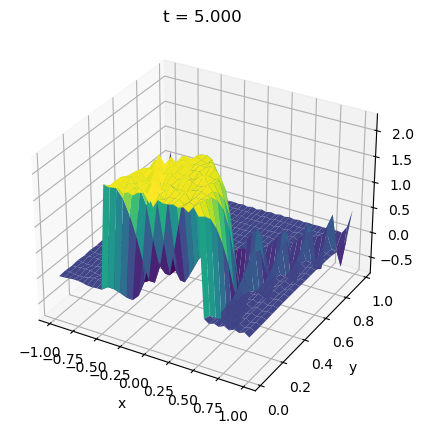

In [3]:
Nx, Ny = 40, 20
mesh = Mesh(Nx, Ny, [-1, 1], [0, 1])
ALPHA, tf = 1e8, 5
p, _, _ = simulate(mesh, ALPHA, tf, CFL=0.5, ss='central', ts='ab2')
# p, _ = simulate(mesh, ALPHA, tf, ss="central", ts="ab2", CFL=0.5)
plot(mesh, p, tf)


In [44]:
import numpy as np
import bocos2
import temporal_schemes2
import fluxes2

def simulate2(mesh, ALPHA, tf, CFL=1., ss='Upwind', ts='Euler', max_its=None):
	t0 = time.time()
	p0 = np.zeros_like(mesh.c)
	bcl = bocos2.DirichletBC([i for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[0]], [1 - math.tanh(ALPHA) for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[0]])
	bcr = bocos2.DirichletBC([i for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[1]], [1 - math.tanh(ALPHA) for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[1]])
	bct = bocos2.DirichletBC([i for i in mesh.fb if mesh.f[i].c.x == mesh.Ly[1]], [1 - math.tanh(ALPHA) for i in mesh.fb if mesh.f[i].c.x == mesh.Ly[1]])
	bcbl = bocos2.DirichletBC([i for i in mesh.fb if mesh.f[i].c.y == mesh.Ly[0] and mesh.f[i].c.x < 0], [1 + math.tanh(ALPHA*(2.*mesh.f[i].c.x+1)) for i in mesh.fb if mesh.f[i].c.y == mesh.Ly[0] and mesh.f[i].c.x < 0])
	bcbr = bocos2.NeumannBC([i for i in mesh.fb if mesh.f[i].c.y == mesh.Ly[0] and mesh.f[i].c.x > 0])
	bcs = [bcl, bcr, bcbl, bcbr]
	for bc in bcs:
		bc.setup(mesh, vel)
	t = 0
	dt = CFL*min(2/mesh.Nx, 1/mesh.Ny) / max([np.linalg.norm(vel(f.c.x, f.c.y)) for f in mesh.f])
	p = p0.copy()
	R = np.zeros_like(p, dtype=float)
	it = 0
	ts = getattr(temporal_schemes2, ts)(mesh)
	ss = getattr(fluxes2, ss)(mesh, vel)
	timers = {}
	t1 = time.time()
	timers['setup'] = t1 - t0
	timers['flux'] = 0
	timers['bocos'] = 0
	timers['update'] = 0
	t0 = time.time()
	while t < tf:
		# update temporal
		if t + dt > tf:
			dt = tf - t
		t = t + dt
		it += 1
		t00 = time.time()
		F = ss(p)
		t01 = time.time()
		timers['flux'] += t01 - t00
		t00 = time.time()
		for bc in bcs:
			F += bc.flux_conv(p)
		t01 = time.time()
		timers['bocos'] += t01 - t00
		t00 = time.time()
		p, R = ts(F, p, dt)
		t01 = time.time()
		timers['update'] += t01 - t00
		if max_its and it >= max_its:
			break
	t1 = time.time()
	timers['sim'] = t1 - t0
	return p, it, timers

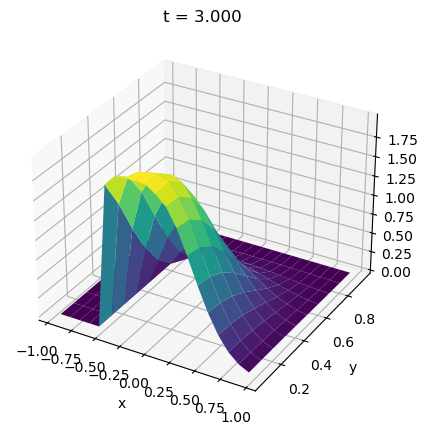

In [51]:
Nx, Ny = 20, 10
mesh = Mesh(Nx, Ny, [-1, 1], [0, 1])
ALPHA, tf = 1e8, 3
p, it, _ = simulate2(mesh, ALPHA, tf, CFL=0.5, ss='Upwind', ts='Euler')
# p, _ = simulate(mesh, ALPHA, tf, ss="central", ts="ab2", CFL=0.5)
plot(mesh, p, tf)

In [52]:
import numpy as np
import bocos3 
import temporal_schemes3
import fluxes3

def simulate3(mesh, ALPHA, tf, CFL=1., ss='Upwind', ts='Euler', max_its=None):
	t0 = time.time()
	p0 = np.zeros_like(mesh.c, dtype=float)
	bcl = bocos3.DirichletBC([i for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[0]], [1 - math.tanh(ALPHA) for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[0]])
	bcr = bocos3.DirichletBC([i for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[1]], [1 - math.tanh(ALPHA) for i in mesh.fb if mesh.f[i].c.x == mesh.Lx[1]])
	bct = bocos3.DirichletBC([i for i in mesh.fb if mesh.f[i].c.x == mesh.Ly[1]], [1 - math.tanh(ALPHA) for i in mesh.fb if mesh.f[i].c.x == mesh.Ly[1]])
	bcbl = bocos3.DirichletBC([i for i in mesh.fb if mesh.f[i].c.y == mesh.Ly[0] and mesh.f[i].c.x < 0], [1 + math.tanh(ALPHA*(2.*mesh.f[i].c.x+1)) for i in mesh.fb if mesh.f[i].c.y == mesh.Ly[0] and mesh.f[i].c.x < 0])
	bcbr = bocos3.NeumannBC([i for i in mesh.fb if mesh.f[i].c.y == mesh.Ly[0] and mesh.f[i].c.x > 0])
	bcs = [bcl, bcr, bcbl, bcbr]
	for bc in bcs:
		bc.setup(mesh, vel)
	t = 0
	dt = CFL*min(2/mesh.Nx, 1/mesh.Ny) / max([np.linalg.norm(vel(f.c.x, f.c.y)) for f in mesh.f])
	p = p0.copy()
	R = np.zeros_like(p)
	it = 0
	ts = getattr(temporal_schemes3, ts)(mesh)
	ss = getattr(fluxes3, ss)(mesh, vel)
	timers = {}
	t1 = time.time()
	timers['setup'] = t1 - t0
	timers['flux'] = 0
	timers['bocos'] = 0
	timers['update'] = 0
	t0 = time.time()
	while t < tf:
		# update temporal
		if t + dt > tf:
			dt = tf - t
		t = t + dt
		it += 1
		t00 = time.time()
		F = ss(p)
		t01 = time.time()
		timers['flux'] += t01 - t00
		t00 = time.time()
		for bc in bcs:
			F += bc.flux_conv(p)
		t01 = time.time()
		timers['bocos'] += t01 - t00
		t00 = time.time()
		p, R = ts(F, p, dt)
		t01 = time.time()
		timers['update'] += t01 - t00
		if max_its and it >= max_its:
			break
	t1 = time.time()
	timers['sim'] = t1 - t0
	return p, it, timers

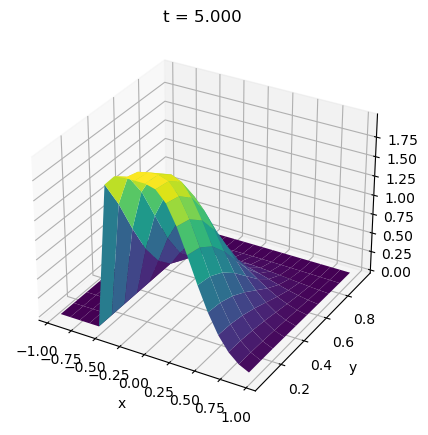

In [53]:
Nx, Ny = 20, 10
mesh = Mesh(Nx, Ny, [-1, 1], [0, 1])
ALPHA, tf = 1e8, 5
p, it, _ = simulate3(mesh, ALPHA, tf, CFL=0.5, ss='Upwind', ts='Euler')
plot(mesh, p, tf)

In [54]:
schemes = [('upwind', 'euler', 0.5)]#, ('upwind', 'ab2', 0.5), ('central', 'euler', 0.5), ('central', 'ab2', 0.5)]
Nxs, Nys = [20, 50, 100, 500], [10, 25, 50, 250]
ALPHA, tf, max_its = 1e8, 5, 10

for scheme in schemes:
	ss, ts, CFL = scheme
	for Nx, Ny in zip(Nxs, Nys):
		mesh = Mesh(Nx, Ny, [-1, 1], [0, 1])
		p, it, timers = simulate(mesh, ALPHA, tf, CFL, ss, ts, max_its)
		msg = f'{ss}, {ts}: N = {Nx}x{Ny}'
		for k, v in timers.items():
			msg += f', t_{k} = {v:.3f}s'
			if k != 'setup':
				msg += f' ({100*v/timers["sim"]:.2f}%)'
		msg += f', its = {it}, its/s = {it/(timers["sim"]):.3f}'
		print(msg)

upwind, euler: N = 20x10, t_setup = 0.002s, t_flux = 0.029s (69.73%), t_bocos = 0.001s (2.93%), t_update = 0.011s (27.29%), t_sim = 0.042s (100.00%), its = 10, its/s = 238.714
upwind, euler: N = 50x25, t_setup = 0.013s, t_flux = 0.203s (72.87%), t_bocos = 0.004s (1.45%), t_update = 0.072s (25.67%), t_sim = 0.279s (100.00%), its = 10, its/s = 35.835
upwind, euler: N = 100x50, t_setup = 0.052s, t_flux = 0.736s (71.85%), t_bocos = 0.006s (0.58%), t_update = 0.282s (27.57%), t_sim = 1.024s (100.00%), its = 10, its/s = 9.765
upwind, euler: N = 500x250, t_setup = 1.235s, t_flux = 18.923s (72.40%), t_bocos = 0.040s (0.15%), t_update = 7.174s (27.45%), t_sim = 26.137s (100.00%), its = 10, its/s = 0.383


In [55]:
schemes = [('Upwind', 'Euler', 0.5)]
Nxs, Nys = [20, 50], [10, 25]
ALPHA, tf, max_its = 1e8, 5, 10

for scheme in schemes:
	ss, ts, CFL = scheme
	for Nx, Ny in zip(Nxs, Nys):
		mesh = Mesh(Nx, Ny, [-1, 1], [0, 1])
		p, it, timers = simulate2(mesh, ALPHA, tf, CFL, ss, ts, max_its)
		msg = f'{ss}, {ts}: N = {Nx}x{Ny}'
		for k, v in timers.items():
			msg += f', t_{k} = {v:.3f}s ({100*v/timers["sim"]:.2f}%)'
		msg += f', its = {it}, its/s = {it/(timers["sim"]):.3f}'
		print(msg)

Upwind, Euler: N = 20x10, t_setup = 0.007s (10.08%), t_flux = 0.023s (33.63%), t_bocos = 0.023s (33.53%), t_update = 0.023s (32.80%), t_sim = 0.070s (100.00%), its = 10, its/s = 143.345
Upwind, Euler: N = 50x25, t_setup = 0.067s (1.91%), t_flux = 1.181s (33.56%), t_bocos = 1.180s (33.54%), t_update = 1.158s (32.90%), t_sim = 3.519s (100.00%), its = 10, its/s = 2.841


In [56]:
schemes = [('Upwind', 'Euler', 0.5)]
Nxs, Nys = [20, 50, 100, 500], [10, 25, 50, 250]
ALPHA, tf, max_its = 1e8, 5, 10

for scheme in schemes:
	ss, ts, CFL = scheme
	for Nx, Ny in zip(Nxs, Nys):
		mesh = Mesh(Nx, Ny, [-1, 1], [0, 1])
		p, it, timers = simulate3(mesh, ALPHA, tf, CFL, ss, ts, max_its)
		msg = f'{ss}, {ts}: N = {Nx}x{Ny}'
		for k, v in timers.items():
			msg += f', t_{k} = {v:.3f}s'
			if k != 'setup':
				msg += f' ({100*v/timers["sim"]:.2f}%)'
		msg += f', its = {it}, its/s = {it/(timers["sim"]):.3f}'
		print(msg)

Upwind, Euler: N = 20x10, t_setup = 0.007s, t_flux = 0.000s (24.55%), t_bocos = 0.000s (46.44%), t_update = 0.000s (24.74%), t_sim = 0.000s (100.00%), its = 10, its/s = 27165.181
Upwind, Euler: N = 50x25, t_setup = 0.046s, t_flux = 0.000s (29.19%), t_bocos = 0.000s (30.86%), t_update = 0.000s (36.33%), t_sim = 0.000s (100.00%), its = 10, its/s = 24146.828
Upwind, Euler: N = 100x50, t_setup = 0.154s, t_flux = 0.000s (30.80%), t_bocos = 0.000s (29.27%), t_update = 0.000s (37.89%), t_sim = 0.001s (100.00%), its = 10, its/s = 10546.402
Upwind, Euler: N = 500x250, t_setup = 3.908s, t_flux = 0.009s (31.48%), t_bocos = 0.008s (26.76%), t_update = 0.012s (41.61%), t_sim = 0.030s (100.00%), its = 10, its/s = 334.690


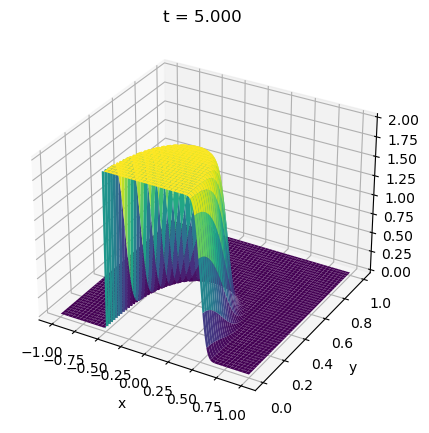

In [60]:
Nx, Ny = 500, 250
mesh = Mesh(Nx, Ny, [-1, 1], [0, 1])
ALPHA, tf = 1e8, 5
p, it, _ = simulate3(mesh, ALPHA, tf, CFL=0.5, ss='Upwind', ts='Euler')
plot(mesh, p, tf)